In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging
import coloredlogs
from dataclasses import asdict

from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import PauliSumOp, AerPauliExpectation, PauliExpectation
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp

In [2]:
from src.expectation import Expectation
from src.fidelity import Fidelity

from src.gradients import ExpectationParameterShift, FidelityParameterShift
from src.gradients import ExpectationReverse, FidelityReverse
from src.dual import GradientDescentOptions

from experiments.models.heisenline import get_model

In [3]:
from dataclasses import dataclass
from typing import Optional, Union
import logging

import numpy as np

from qiskit.circuit import QuantumCircuit
from qiskit.opflow import PauliSumOp

from src.expectation import Expectation
from src.fidelity import Fidelity
from src.gradients import Gradient, FidelityGradient, ExpectationParameterShift, FidelityParameterShift


logger = logging.getLogger(__name__)


@dataclass
class GradientDescentOptions:
    _learning_rate: Union[float, np.ndarray] = 0.01

    @property
    def learning_rate(self):
        if isinstance(self._learning_rate, float):
            return self._learning_rate * np.ones(self.maxiter)
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, value):
        self._learning_rate = value

    maxiter: int = 100
    losstol: float = 1e-5
    gradtol: float = 1e-3


@dataclass
class DualITEResult:
    times: list
    parameters: list
    energies: list
    losses: list
    gradients: list
    thetas: list


class DualITE:
    """Imaginary time evolution using the QNG minimization formulation."""

    def __init__(
        self,
        ansatz: QuantumCircuit,
        initial_parameters: np.ndarray,
        expectation: Expectation,
        fidelity: Fidelity,
        expectation_gradient: Optional[Gradient] = None,
        fidelity_gradient: Optional[FidelityGradient] = None,
        norm_factor: float = 1,
        arccos: bool = False,
        gd_options: Optional[GradientDescentOptions] = None,
        warmstart: Union[bool, np.ndarray] = True,
        timestep_normalization: bool = False,
    ):
        """
        Args:
            ansatz: The ansatz circuit.
            expectation: The expectation converter to use for the basis transformation.
            fidelity: The fidelity of the two quantum states.
            expectation_gradient: The expectation gradient.
            fidelity_gradient: The fidelity gradient.
            norm_factor: Add the norm of the update step to the loss with this factor.
            arccos: Use arccos instead of 1 - fidelity.
            gd_options: Gradient descent options.
            warmstart: If True use the gradient of the last iteration as initial step.
                If a vector, this vector is used as first initial guess and then the other
                steps are warmstarted. If False a zero vector is used as initial guess.
        """
        self.ansatz = ansatz
        self.initial_parameters = initial_parameters
        self.expectation = expectation
        self.fidelity = fidelity

        self.expectation.circuit = ansatz
        self.fidelity.right_circuit = ansatz
        self.fidelity.left_circuit = ansatz

        if expectation_gradient is None:
            expectation_gradient = ExpectationParameterShift()

        expectation_gradient.expectation = self.expectation
        self.expectation_gradient = expectation_gradient

        if fidelity_gradient is None:
            fidelity_gradient = FidelityParameterShift()

        fidelity_gradient.fidelity = self.fidelity
        self.fidelity_gradient = fidelity_gradient

        self.norm_factor = norm_factor
        self.arccos = arccos

        if gd_options is None:
            gd_options = GradientDescentOptions()

        self.gd_options = gd_options
        self.warmstart = warmstart
        self.timestep_normalization = timestep_normalization

    def step(
        self,
        dt: float,
        theta: np.ndarray,
        x0: Optional[np.ndarray] = None,
    ):
        """Perform a single step of the time evolution.

        Args:
            dt: The time step.
            theta: The current parameters.
            x0: The point at which to start the optimization (0 per default).

        Returns:
            The new parameters, the losses and gradient norms of the optimization.
        """
        logger.info("Starting dual optimization...")
        losses = []
        gradients = []
        thetas = [theta]
        
        # factor to multiply the loss function with
        if self.timestep_normalization:
            factor = dt
        else:
            factor = 1

        energy_gradient = 0.5 * self.expectation_gradient.compute(theta)
#         print("Energy grad", energy_gradient)

        def infidelity_gradient(next_theta):
            return -self.fidelity_gradient.compute(theta, next_theta)

        if not hasattr(self.gd_options.learning_rate, "__iter__"):
            maxiter = self.gd_options.maxiter
            learning_rate = self.gd_options.learning_rate
            eta = iter(np.ones(maxiter) * learning_rate)
        else:
            eta = iter(self.gd_options.learning_rate)

        if x0 is None:
            x = 0.01 * np.ones_like(theta)
        else:
            x = x0

        if self.arccos:
            infid = np.arccos(np.sqrt(self.fidelity(theta, theta + x))) ** 2
        else:
            infid = 1 - self.fidelity.evaluate(theta, theta + x)

        loss = np.dot(x, energy_gradient) + 0.5 / dt * infid * (
            1 + self.norm_factor * np.linalg.norm(x) ** 2
        )
        loss *= factor
        losses.append(loss)

        for _ in range(self.gd_options.maxiter):
            fid = self.fidelity.evaluate(theta, theta + x)
#             print(f"Step {_}, fid: {fid}")
                
            if self.arccos:
                infid = np.arccos(np.sqrt(fid)) ** 2
            else:
                infid = 1 - fid

            x_norm = np.linalg.norm(x)

            # compute gradient
            infid_derivative = infidelity_gradient(theta + x)

            if self.arccos:
                if np.isclose(fid, 1):
                    infid_derivative = infid_derivative * np.sqrt(2)
                else:
                    infid_derivative = (
                        infid_derivative * np.arccos(np.sqrt(fid)) / np.sqrt(2 * fid * (1 - fid))
                    )

            d1 = infid_derivative * (1 + self.norm_factor * x_norm**2)
            d2 = 2 * self.norm_factor * x * infid
            gradient = energy_gradient + 0.5 / dt * (d1 + d2)
            gradient *= factor

            # update iterate
            x = x - next(eta) * gradient

            loss = np.dot(x, energy_gradient) + 0.5 / dt * infid * (
                1 + self.norm_factor * x_norm**2
            )
            loss *= factor

            # blocking criterion
            if self.gd_options.blocking and (loss - losses[-1] > 0.01):
                logger.info("-- Rejecting GD step.")
                continue

            losses.append(loss)
            gradients.append(np.linalg.norm(gradient))
            thetas.append(theta + x)

            logger.info("-- Loss: %f, gradientnorm: %f", loss, np.linalg.norm(gradient))

            if np.abs(losses[-1] - losses[-2]) < self.gd_options.losstol:
                print("-- Reached losstol.")
                break

            if np.linalg.norm(gradient) < self.gd_options.gradtol:
                print("-- Reached tolerance.")
                break

        return theta + x, losses, gradients, thetas

    def evolve(self, hamiltonian: PauliSumOp, final_time: float, timestep: float) -> DualITEResult:
        """Evolve the ansatz circuit for a given Hamiltonian.

        Args:
            hamiltonian: The Hamiltonian to evolve under.
            final_time: The final time.
            timestep: The timestep.

        Returns:
            The result of the evolution.
        """
        self.expectation.hamiltonian = hamiltonian
        energies = [self.expectation.evaluate(self.initial_parameters)]
        parameters = [self.initial_parameters]

        losses = []
        gradients = []
        thetas = []

        num_timesteps = int(np.ceil(final_time / timestep))
        times = np.linspace(0, final_time, num_timesteps + 1).tolist()

        if isinstance(self.warmstart, np.ndarray):
            x0 = self.warmstart
        else:
            x0 = 0.01 * np.ones(self.initial_parameters.size)

        for i in range(num_timesteps):
            logger.info("Time %s/%s", times[i], final_time)
            print("-- Warmstarting with initial guess:", x0)
            next_theta, losses_i, gradients_i, thetas_i = self.step(timestep, parameters[-1], x0)

            if self.warmstart is not False:  # to cover the case of np.ndarray
                x0 = next_theta - parameters[-1]

            parameters.append(next_theta)
            energies.append(self.expectation.evaluate(next_theta))
            losses.append(losses_i)
            gradients.append(gradients_i)
            thetas.append(thetas_i)

        return DualITEResult(times, parameters, energies, losses, gradients, thetas)


In [4]:
hamiltonian, circuit, initial_parameters = get_model(num_sites=3, reps=3, J=0.25, g=-1)

In [24]:
gd_options = GradientDescentOptions()
gd_options.losstol = 0
gd_options.gradtol = 0
gd_options.maxiter = 300
gd_options.blocking = False
gd_options.learning_rate = 0.01

In [25]:
def run(shots, timestep_normalization=False): 
    if shots == "sv":
        backend = AerSimulator(method="statevector")
        expectation_converter = AerPauliExpectation()
        shots = None
        expectation_gradient = ExpectationReverse()
        fidelity_gradient = FidelityReverse()
    else:
        backend = AerSimulator()
        expectation_converter = PauliExpectation()
        expectation_gradient = ExpectationParameterShift()
        fidelity_gradient = FidelityParameterShift()


    expectation = Expectation(backend, expectation_converter, shots=shots)
    fidelity = Fidelity(backend, expectation_converter, shots=shots)
    
    dual = DualITE(
        circuit,
        initial_parameters,
        expectation,
        fidelity,
        expectation_gradient,
        fidelity_gradient,
    #     warmstart=False,
        warmstart=np.ones_like(initial_parameters) * 0.01,
        norm_factor=1,
        gd_options=gd_options,
        timestep_normalization=timestep_normalization,
    )
    
    return dual.evolve(hamiltonian, final_time=0.05, timestep=0.05)

In [22]:
gd_sv = run("sv")
gd_s1e2 = run(100)
gd_s1e3 = run(1000)
gd_s1e4 = run(10_000)

-- Warmstarting with initial guess: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


In [26]:
sv = run("sv")

-- Warmstarting with initial guess: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


In [27]:
s100 = run(100)

-- Warmstarting with initial guess: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


In [28]:
s1e3 = run(1000)

-- Warmstarting with initial guess: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


In [29]:
s1e4 = run(10_000)

-- Warmstarting with initial guess: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


In [120]:
norm_sv = run("sv", True)
norm_s100 = run(100, True)
norm_s1e3 = run(1000, True)
norm_s1e4 = run(10_000, True)

-- Warmstarting with initial guess: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
-- Warmstarting with initial guess: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
-- Warmstarting with initial guess: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
-- Warmstarting with initial guess: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


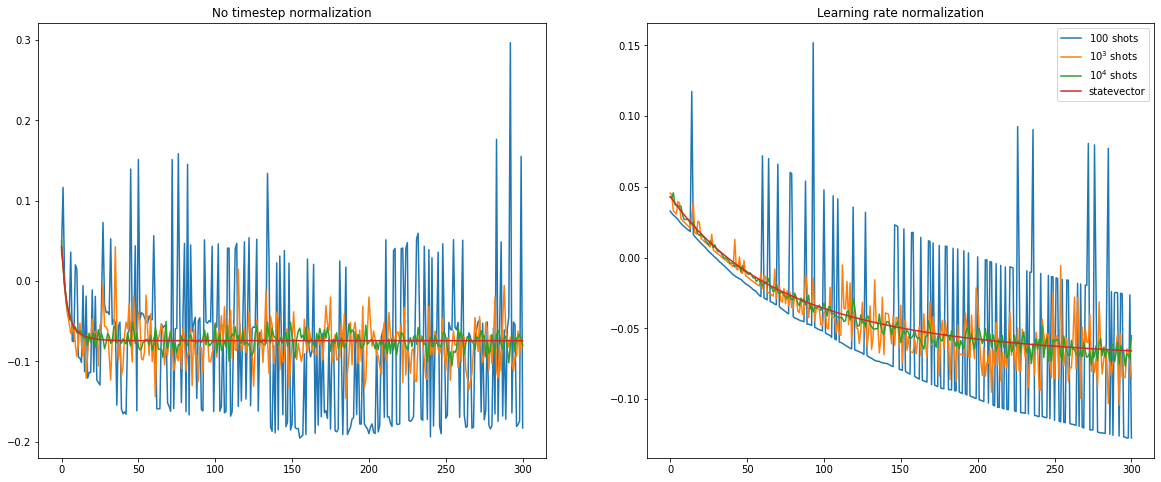

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].plot(s100.losses[0], label="$100$ shots")
axs[0].plot(s1e3.losses[0], label=r"$10^3$ shots")
axs[0].plot(s1e4.losses[0], label=r"$10^4$ shots")
axs[0].plot(sv.losses[0], label="statevector")
axs[0].set_title("No timestep normalization")

# axs[1].plot(norm_s100.losses[0], label="$100$ shots")
# axs[1].plot(norm_s1e3.losses[0], label=r"$10^3$ shots")
# axs[1].plot(norm_s1e4.losses[0], label=r"$10^4$ shots")
# axs[1].plot(norm_sv.losses[0], label="statevector")
# axs[1].set_title("Timestep normalization")

i = 1
axs[1].plot(gd_s1e2.losses[0], label="$100$ shots")
axs[1].plot(gd_s1e3.losses[0], label=r"$10^3$ shots")
axs[1].plot(gd_s1e4.losses[0], label=r"$10^4$ shots")
axs[1].plot(gd_sv.losses[0], label="statevector")
axs[1].set_title("Learning rate normalization")
plt.legend()

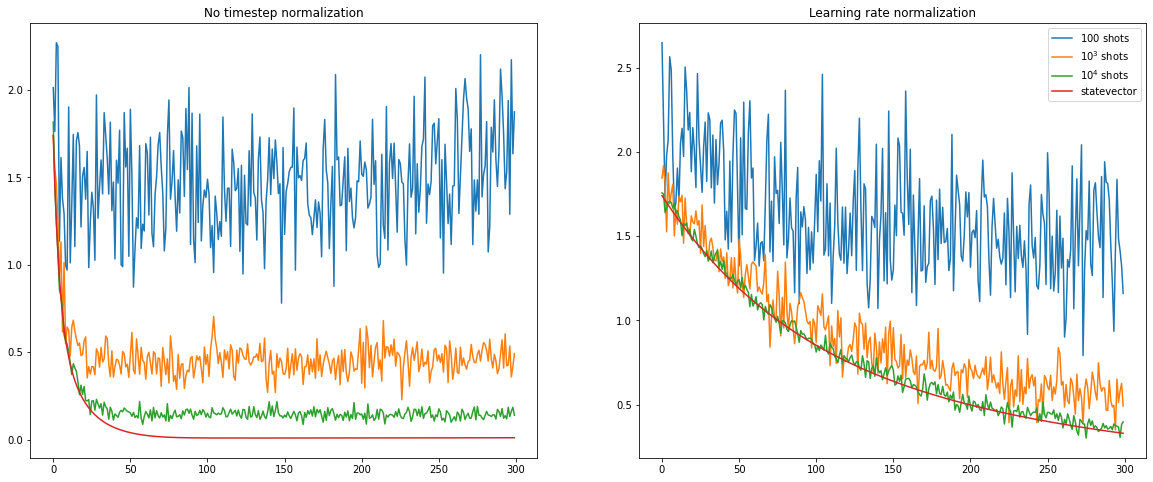

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].plot(s100.gradients[0], label="$100$ shots")
axs[0].plot(s1e3.gradients[0], label=r"$10^3$ shots")
axs[0].plot(s1e4.gradients[0], label=r"$10^4$ shots")
axs[0].plot(sv.gradients[0], label="statevector")
axs[0].set_title("No timestep normalization")

# axs[1].plot(norm_s100.losses[0], label="$100$ shots")
# axs[1].plot(norm_s1e3.losses[0], label=r"$10^3$ shots")
# axs[1].plot(norm_s1e4.losses[0], label=r"$10^4$ shots")
# axs[1].plot(norm_sv.losses[0], label="statevector")
# axs[1].set_title("Timestep normalization")

i = 1
axs[1].plot(gd_s1e2.gradients[0], label="$100$ shots")
axs[1].plot(gd_s1e3.gradients[0], label=r"$10^3$ shots")
axs[1].plot(gd_s1e4.gradients[0], label=r"$10^4$ shots")
axs[1].plot(gd_sv.gradients[0], label="statevector")
axs[1].set_title("Learning rate normalization")
plt.legend()

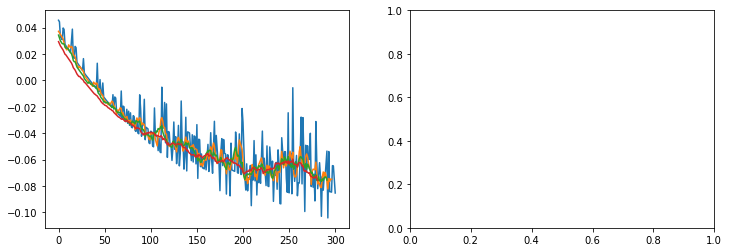

In [331]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(gd_s1e3.losses[0], label=r"$10^3$ shots")
axs[0].plot(np.convolve(gd_s1e3.losses[0], np.ones(5) / 5, "valid"), label=r"$10^3$ shots")
axs[0].plot(np.convolve(gd_s1e3.losses[0], np.ones(10) / 10, "valid"), label=r"$10^3$ shots")
axs[0].plot(np.convolve(gd_s1e3.losses[0], np.ones(20) / 20, "valid"), label=r"$10^3$ shots")


In [124]:
s100_l2 = [np.linalg.norm(sv.thetas[0][i] - s100.thetas[0][i]) for i, _ in enumerate(sv.thetas[0])]
s1e3_l2 = [np.linalg.norm(sv.thetas[0][i] - s1e3.thetas[0][i]) for i, _ in enumerate(sv.thetas[0])]
s1e4_l2 = [np.linalg.norm(sv.thetas[0][i] - s1e4.thetas[0][i]) for i, _ in enumerate(sv.thetas[0])]

norm_s100_l2 = [np.linalg.norm(norm_sv.thetas[0][i] - norm_s100.thetas[0][i]) for i, _ in enumerate(sv.thetas[0])]
norm_s1e3_l2 = [np.linalg.norm(norm_sv.thetas[0][i] - norm_s1e3.thetas[0][i]) for i, _ in enumerate(sv.thetas[0])]
norm_s1e4_l2 = [np.linalg.norm(norm_sv.thetas[0][i] - norm_s1e4.thetas[0][i]) for i, _ in enumerate(sv.thetas[0])]

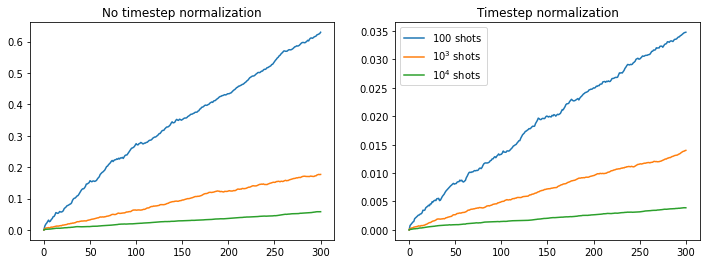

In [127]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(s100_l2, label="$100$ shots")
axs[0].plot(s1e3_l2, label=r"$10^3$ shots")
axs[0].plot(s1e4_l2, label=r"$10^4$ shots")
axs[0].set_title("No timestep normalization")

axs[1].plot(norm_s100_l2, label="$100$ shots")
axs[1].plot(norm_s1e3_l2, label=r"$10^3$ shots")
axs[1].plot(norm_s1e4_l2, label=r"$10^4$ shots")
axs[1].set_title("Timestep normalization")
plt.legend()

In [133]:
ref = sv.thetas[0][-1]
s100_l2final = [np.linalg.norm(ref - s100.thetas[0][i]) for i, _ in enumerate(sv.thetas[0])]
s1e3_l2final = [np.linalg.norm(ref - s1e3.thetas[0][i]) for i, _ in enumerate(sv.thetas[0])]
s1e4_l2final = [np.linalg.norm(ref - s1e4.thetas[0][i]) for i, _ in enumerate(sv.thetas[0])]

norm_ref = norm_sv.thetas[0][-1]
norm_s100_l2final = [np.linalg.norm(norm_ref - norm_s100.thetas[0][i]) for i, _ in enumerate(sv.thetas[0])]
norm_s1e3_l2final = [np.linalg.norm(norm_ref - norm_s1e3.thetas[0][i]) for i, _ in enumerate(sv.thetas[0])]
norm_s1e4_l2final = [np.linalg.norm(norm_ref - norm_s1e4.thetas[0][i]) for i, _ in enumerate(sv.thetas[0])]

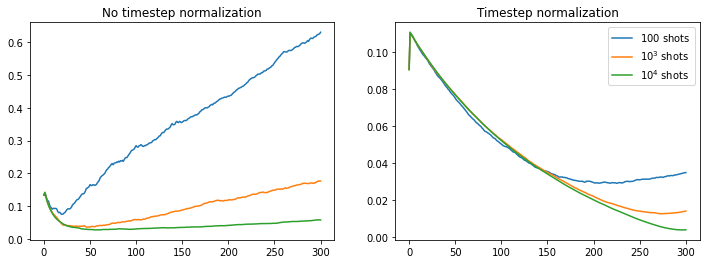

In [134]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(s100_l2final, label="$100$ shots")
axs[0].plot(s1e3_l2final, label=r"$10^3$ shots")
axs[0].plot(s1e4_l2final, label=r"$10^4$ shots")
axs[0].set_title("No timestep normalization")

axs[1].plot(norm_s100_l2final, label="$100$ shots")
axs[1].plot(norm_s1e3_l2final, label=r"$10^3$ shots")
axs[1].plot(norm_s1e4_l2final, label=r"$10^4$ shots")
axs[1].set_title("Timestep normalization")
plt.legend()

In [145]:
s100_diff = np.linalg.norm(np.diff(s100.thetas[0]), axis=1)
s1e3_diff = np.linalg.norm(np.diff(s1e3.thetas[0]), axis=1)
s1e4_diff = np.linalg.norm(np.diff(s1e4.thetas[0]), axis=1)

norm_s100_diff = np.linalg.norm(np.diff(norm_s100.thetas[0]), axis=1)
norm_s1e3_diff = np.linalg.norm(np.diff(norm_s1e3.thetas[0]), axis=1)
norm_s1e4_diff = np.linalg.norm(np.diff(norm_s1e4.thetas[0]), axis=1)

Text(0.5, 1.0, 'Timestep normalization')

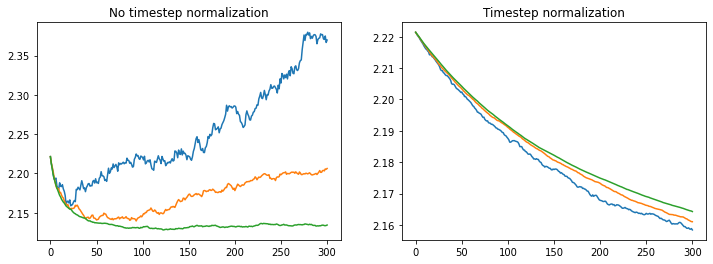

In [146]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(s100_diff, label="$100$ shots")
axs[0].plot(s1e3_diff, label=r"$10^3$ shots")
axs[0].plot(s1e4_diff, label=r"$10^4$ shots")
axs[0].set_title("No timestep normalization")

axs[1].plot(norm_s100_diff, label="$100$ shots")
axs[1].plot(norm_s1e3_diff, label=r"$10^3$ shots")
axs[1].plot(norm_s1e4_diff, label=r"$10^4$ shots")
axs[1].set_title("Timestep normalization")

In [16]:
theta = initial_parameters
x = np.ones_like(initial_parameters) * 0.01

In [24]:
values = [fidelity.evaluate(theta, theta + x) for _ in range(1000)]

In [25]:
print(np.mean(values))
print(np.std(values))

0.999259765625
0.0008487873178180116


In [11]:
hamiltonian

PauliSumOp(SparsePauliOp(['IXX', 'XXI', 'IYY', 'YYI', 'IZZ', 'ZZI', 'IIZ', 'IZI', 'ZII'],
              coeffs=[ 0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,
 -1.  +0.j, -1.  +0.j, -1.  +0.j]), coeff=1.0)

In [47]:
help(ExpectationReverse)

Help on class ExpectationReverse in module src.gradients.expectation_reverse:

class ExpectationReverse(src.gradients.gradient.Gradient)
 |  ExpectationReverse(expectation: Optional[src.expectation.Expectation] = None) -> None
 |  
 |  Expectation value gradient with the classically fast reverse mode.
 |  
 |  Method resolution order:
 |      ExpectationReverse
 |      src.gradients.gradient.Gradient
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  compute(self, values: numpy.ndarray) -> numpy.ndarray
 |      Compute the expectation value gradient.
 |      
 |      Args:
 |          values: The values at which the gradient is computed.
 |      
 |      Returns:
 |          The gradient of the expectation value at ``values``.
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __abstractmethods__ = frozenset()
 |  
 |  ----------------------------------------------------------

In [223]:
backend = AerSimulator(method="statevector")
expectation_converter = AerPauliExpectation()
shots = None

expectation = Expectation(backend, expectation_converter, hamiltonian, circuit, shots=shots)
fidelity = Fidelity(backend, expectation_converter, circuit, circuit, shots=shots)
expectation_gradient = ExpectationReverse(expectation)
fidelity_gradient = FidelityReverse(fidelity)

In [158]:
shots = 1024
backend = AerSimulator()
expectation_converter = PauliExpectation()

expectation = Expectation(backend, expectation_converter, hamiltonian, circuit, shots=shots)
fidelity = Fidelity(backend, expectation_converter, circuit, circuit, shots=shots)
expectation_gradient = ExpectationParameterShift(expectation)
fidelity_gradient = FidelityParameterShift(fidelity)

In [224]:
def get_loss_and_gradient(theta, dt, norm_factor=1, timestep_normalization=True):
    losses = []
    gradients = []
    thetas = [theta]

    # factor to multiply the loss function with
    if timestep_normalization:
        factor = dt
    else:
        factor = 1

    energy_gradient = 0.5 * expectation_gradient.compute(theta)
    print(energy_gradient.dot(np.zeros_like(theta)))

    def loss(x):
        infid = 1 - fidelity.evaluate(theta, theta + x)
        penalty = norm_factor * np.linalg.norm(x) ** 2

        res = energy_gradient.dot(x) + 0.5 / dt * infid * (1 + penalty)
        return res * factor
    
    
    def gradient(x):
        infid_derivative = -fidelity_gradient.compute(theta, theta + x)
        infid = 1 - fidelity.evaluate(theta, theta + x)
        
        d1 = infid_derivative * (1 + norm_factor * np.linalg.norm(x) ** 2)
        d2 = 2 * norm_factor * x * infid
        res = energy_gradient + 0.5 / dt * (d1 + d2)
        return res * factor

    return loss, gradient

In [225]:
loss, gradient = get_loss_and_gradient(initial_parameters, dt=0.01)

0.0


In [226]:
gradient(np.zeros(circuit.num_parameters))

array([-4.53020457e-17,  5.59950447e-18,  5.00000000e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -3.02754325e-18,  5.00000000e-03,
        5.00000000e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        8.46445932e-18,  5.59950447e-18,  5.00000000e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.00000000e-03,  5.00000000e-03,
        5.00000000e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [227]:
def gd(fun, x0, jac, maxiter, eta):
    values = [fun(x0)]
    xs = [x0]    

    x = x0
    for i in range(maxiter):
        x = x - eta * jac(x)
        
        xs.append(x)
        values.append(fun(x))
        
    return xs, values

In [228]:
def spsa(fun, x0, eps, maxiter, eta):
    values = [fun(x0)]
    xs = [x0]
    
    x = x0
    for i in range(maxiter):
        delta = (-1) ** np.random.randint(0, 2, x0.size)
        grad = (fun(x + eps * delta) - fun(x - eps * delta)) / (2 * eps) * delta
        x = x - eta * grad
        
        xs.append(x)
        values.append(fun(x))
        
    return xs, values

In [229]:
x0 = np.ones(circuit.num_parameters) * 0.01

In [230]:
opt, losses = gd(loss, x0, gradient, maxiter=300, eta=0.01)

In [235]:
opt_spsa, losses_spsa = spsa(loss, x0, eps=0.01, maxiter=1000, eta=0.01)

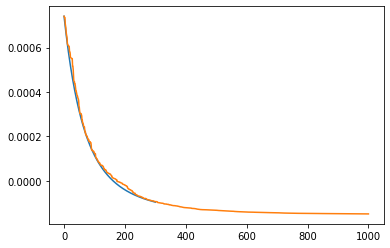

In [236]:
plt.plot(losses)
plt.plot(losses_spsa)

In [244]:
def F(x):
    return fidelity.evaluate(initial_parameters, initial_parameters + x)

dE = expectation_gradient.compute(initial_parameters)

In [255]:
v = [(1 - F(x)) / 0.01 + dE.dot(x) / 2 for x in opt_spsa]
d = [np.linalg.norm(ex - x) for x in opt_spsa]
# v = [loss - dE.dot(x) / 4 for loss, x in zip(losses, opt)]

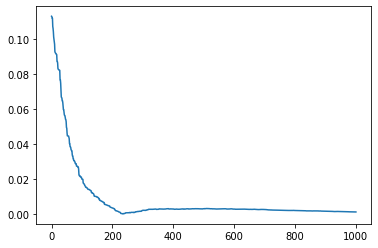

In [259]:
plt.plot(np.abs(v))
# plt.plot(d)

In [278]:
n = 2
pert = 0.1 * np.random.random((n, n))
A = np.identity(n) + pert + pert.T
b = 2 * np.random.random(n)

In [279]:
def f(x):
    return 0.5 * x.dot(A.dot(x)) + b.dot(x)

def jac(x):
    return A.dot(x) + b

In [326]:
xs, ls = gd(f, x0=np.ones(n), jac=jac, maxiter=1000, eta=0.01)

In [327]:
t = -b.dot(np.linalg.inv(A).dot(b)) / 2

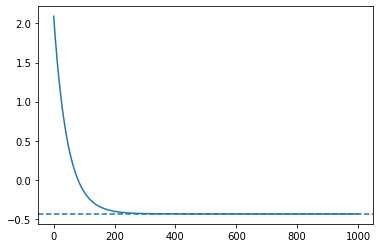

In [328]:
plt.plot(ls)
plt.axhline(t, ls="--")

In [329]:
v = [x.dot(A.dot(x)) + b.dot(x) for x in xs]
orth = [x.dot()]

NameError: name 'x' is not defined

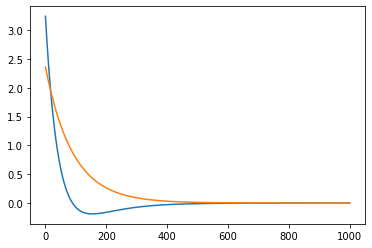

In [330]:
plt.plot(v)
# plt.plot([0.5 * x.dot(b) for x in xs])
# plt.plot(np.abs([x.dot(A.dot(x) + b) for x in xs]))
plt.plot([np.linalg.norm(A.dot(x) + b) for x in xs])
# plt.xlim([80, 100])
# plt.ylim([-0.5, 0.2])

In [303]:
xs[-1]

array([-0.84656934,  0.06981458])

In [314]:
A.dot(xs[89]).dot(xs[89])

0.15830107175475452

In [304]:
d = [A.dot(x) + b for x in xs]

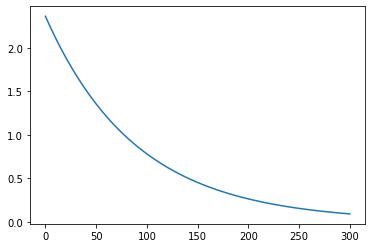

In [305]:
# plt.plot(v)
plt.plot([np.linalg.norm(d_i) for d_i in d])

In [260]:
from surfer.qfi import ReverseQFI

g = ReverseQFI().compute(circuit, initial_parameters)

In [250]:
ex = np.linalg.solve(g + 0.01 * np.identity(dE.size), dE/2)

In [254]:
np.round(ex, decimals=2)

array([-0.  , -0.  ,  0.12,  0.  ,  0.  ,  0.  , -0.  ,  0.25,  0.12,
        0.  ,  0.  ,  0.  ,  0.  , -0.  ,  0.12,  0.  ,  0.  ,  0.  ,
        0.5 ,  0.25,  0.12,  0.  ,  0.  ,  0.  ])

In [261]:
v = [x.dot(g.dot(x)) / 0.01 + dE.dot(x) / 2 for x in opt_spsa]

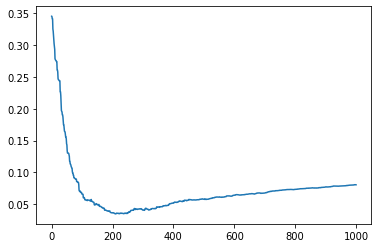

In [262]:
plt.plot(v)